In [1]:
# Data Preprocessing
import numpy as np
from six.moves import cPickle

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Neural network
import tensorflow as tf
tf.InteractiveSession()

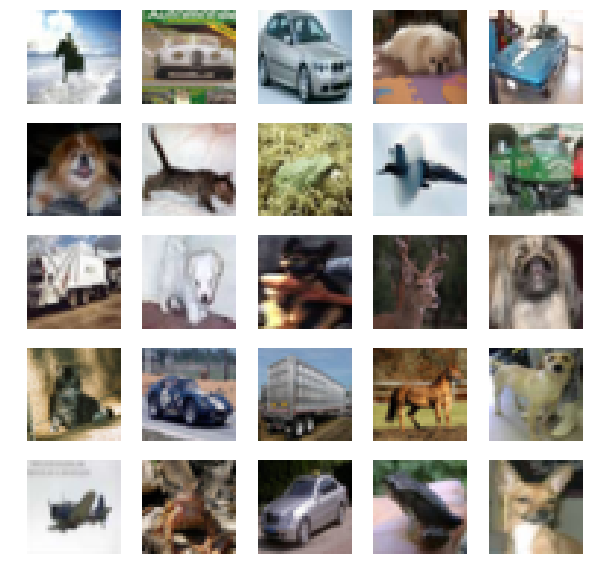

In [2]:
# data loading into python dictionary
f = open('cifar-10-batches-py/data_batch_1', 'rb')      
datadict = cPickle.load(f,encoding='latin1')
f.close()

X = datadict['data']       # image vectors
Y = datadict['labels']     # label value

# we reshape the image in 3x32x32
# x and y axis are swaped so we use transpose to correct the axis
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype('uint8')   # shape of X = [10000,32,32,3]

Y = np.array(Y)

# showing images
fig, axis1 = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        k = np.random.choice(range(len(X)))
        axis1[i][j].set_axis_off()               # trun off values of axis and remove black border
        axis1[i][j].imshow(X[k:k+1][0])
        

In [3]:
height = 32            # height of image
width = 32             # width of image 
num_classes = 10       # number of classes
dropout = 0.7 
learning_rate = .001

# one hot encoding of labels
label = (tf.contrib.layers.one_hot_encoding(labels=Y,num_classes=num_classes)).eval()  

# Define Placeholders
x_image = tf.placeholder(tf.float32, [None, height, width, 3], name="X_image")
y_image = tf.placeholder(tf.float32, [None, num_classes], name="Y_image")
keep_prob = tf.placeholder(tf.float32, name="Dropout")

In [4]:
train_batch_size = 128


def conv_layer(input, weight, bias, maxpool="maxpool",name="conv"):
    with tf.name_scope(name):
        conv = tf.nn.conv2d(input, weight, strides=[1, 1, 1, 1], padding="SAME")
        act = tf.nn.relu(conv + bias)
        
        tf.summary.histogram("weight", weight)
        tf.summary.histogram("biases", bias)
        tf.summary.histogram("activations", act)
        
        if maxpool == "maxpool":
            output = tf.nn.max_pool(act, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="SAME")
        else:
            output = act
        
        return output

def fc_layer(input, weight, bias, name="fc"):
    with tf.name_scope(name):
        act = tf.matmul(input, weight) + bias
        
        tf.summary.histogram("weight", weight)
        tf.summary.histogram("biases", bias)
        
        return act
    
def random_batch():
    # Number of images in the training-set.
    num_images = len(X)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = X[idx, :, :, :]
    y_batch = label[idx, :]

    return x_batch, y_batch

In [5]:
def alexnet(x, weights, biases, dropout=1.0):
    '''
    Full (simplified) AlexNet architecture:
    [227x227x3] INPUT
    [55x55x96] CONV1: 96 11x11 filters at stride 4, pad 0
    [27x27x96] MAX POOL1: 3x3 filters at stride 2
    [27x27x96] NORM1: Normalization layer
    [27x27x256] CONV2: 256 5x5 filters at stride 1, pad 2
    [13x13x256] MAX POOL2: 3x3 filters at stride 2
    [13x13x256] NORM2: Normalization layer
    [13x13x384] CONV3: 384 3x3 filters at stride 1, pad 1
    [13x13x384] CONV4: 384 3x3 filters at stride 1, pad 1
    [13x13x256] CONV5: 256 3x3 filters at stride 1, pad 1
    [6x6x256] MAX POOL3: 3x3 filters at stride 2
    [4096] FC6: 4096 neurons
    [4096] FC7: 4096 neurons
    [1000] FC8: 1000 neurons (class scores)
    '''
    #layer1                     ([1,1,1,1] instead of strides=[1,4,4,1])                size of output                                     size
    conv_1 = conv_layer(x, weights['w1'], biases['b1'], "maxpool", "conv_1")                     # 16*16*96 
    norm_1 = tf.nn.local_response_normalization(conv_1, depth_radius=4,
                                                bias=1.0, alpha=12e-05, beta=0.75)      # 16*16*96
    
    #layer2
    conv_2 = conv_layer(norm_1, weights['w2'], biases['b2'], "maxpool", "conv_2")               # 8*8*256
    norm_2 = tf.nn.local_response_normalization(conv_2, depth_radius=4,
                                                bias=1.0, alpha=12e-05, beta=0.75)      # 8*8*256   
    
    #layer3
    conv_3 = conv_layer(norm_2, weights['w3'], biases['b3'], "no-maxpool", "conv_3")           # 8*8*384                                                                                 # 8*8*384 
            
    #layer4
    conv_4 = conv_layer(conv_3, weights['w4'], biases['b4'], "no-maxpool", "conv_4")           # 8*8*384 
        
    #layer5
    conv_5 = conv_layer(conv_4, weights['w5'], biases['b5'], "maxpool", "conv_5")              # 4*4*256   
    
    #layer6
    reshape_1 = tf.reshape(conv_5, [-1, int(np.prod(conv_5.get_shape()[1:]))])          # -1, 4096 
    
    fc_1 = fc_layer(reshape_1, weights['w6'], biases['b6'], "fc_1")                          # 1024 (instead of 4096)
    relu_fc_1 = tf.nn.relu(fc_1)
      
    #layer7
    fc_2 = fc_layer(relu_fc_1, weights['w7'], biases['b7'], "fc_2")                             #1024 (instead of 4096) 
    relu_fc_2 = tf.nn.relu(fc_2)
    
    #output layer
    output = fc_layer(relu_fc_2, weights['out'], biases['out'], "output")                             #10 

    return output

In [6]:
weights = {
        'w1' : tf.Variable(tf.random_normal([11,11,3,96])),
        'w2' : tf.Variable(tf.random_normal([5,5,96,256])),
        'w3' : tf.Variable(tf.random_normal([3,3,256,384])),
        'w4' : tf.Variable(tf.random_normal([3,3,384,384])),
        'w5' : tf.Variable(tf.random_normal([3,3,384,256])),
        'w6' : tf.Variable(tf.random_normal([4*4*256,1024])),
        'w7' : tf.Variable(tf.random_normal([1024,1024])),
        'out' : tf.Variable(tf.random_normal([1024,10]))
        }

biases = {
        'b1' : tf.Variable(tf.random_normal([96])),
        'b2' : tf.Variable(tf.random_normal([256])),
        'b3' : tf.Variable(tf.random_normal([384])),
        'b4' : tf.Variable(tf.random_normal([384])),
        'b5' : tf.Variable(tf.random_normal([256])),
        'b6' : tf.Variable(tf.random_normal([1024])),
        'b7' : tf.Variable(tf.random_normal([1024])),
        'out' : tf.Variable(tf.random_normal([10]))
        }

print("weights ready")

weights ready


In [7]:

pred = alexnet(x_image, weights, biases, keep_prob)

with tf.name_scope("Cross_entropy"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_image, logits=pred))
    tf.summary.scalar("cross_entropy", cross_entropy)
    
with tf.name_scope("Train_step"):    
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope("Accuracy"):
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y_image, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)
    
print('Network ready')

Network ready


In [ ]:


sess = tf.Session()
sess.run(tf.global_variables_initializer())
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("/tmp/alex_net")
writer.add_graph(sess.graph)
for i in range(20000):
    x_data,y_label = random_batch()
    summary, train_accuracy = sess.run([merged_summary, accuracy], feed_dict={x_image: x_data, y_image: y_label, keep_prob: 1})
    writer.add_summary(summary, i)
    print('step %d, training accuracy %g' % (i, train_accuracy))
    sess.run(train_step, feed_dict={x_image: x_data, y_image: y_label, keep_prob: dropout})
print("depend on result")

step 0, training accuracy 0.0703125
step 1, training accuracy 0.109375
step 2, training accuracy 0.117188
step 3, training accuracy 0.109375
step 4, training accuracy 0.148438
step 5, training accuracy 0.164062
step 6, training accuracy 0.140625
step 7, training accuracy 0.140625
step 8, training accuracy 0.109375
step 9, training accuracy 0.171875
step 10, training accuracy 0.109375
step 11, training accuracy 0.164062
step 12, training accuracy 0.101562
step 13, training accuracy 0.0703125
step 14, training accuracy 0.203125
step 15, training accuracy 0.148438
step 16, training accuracy 0.171875
step 17, training accuracy 0.203125
step 18, training accuracy 0.195312
step 19, training accuracy 0.148438
step 20, training accuracy 0.140625
step 21, training accuracy 0.148438
step 22, training accuracy 0.1875
step 23, training accuracy 0.226562
step 24, training accuracy 0.210938
step 25, training accuracy 0.179688
step 26, training accuracy 0.140625
step 27, training accuracy 0.257812
st

step 228, training accuracy 0.367188
step 229, training accuracy 0.445312
step 230, training accuracy 0.335938
step 231, training accuracy 0.4375
step 232, training accuracy 0.335938
step 233, training accuracy 0.34375
step 234, training accuracy 0.414062
step 235, training accuracy 0.46875
step 236, training accuracy 0.320312
step 237, training accuracy 0.367188
step 238, training accuracy 0.398438
step 239, training accuracy 0.398438
step 240, training accuracy 0.382812
step 241, training accuracy 0.328125
step 242, training accuracy 0.453125
step 243, training accuracy 0.429688
step 244, training accuracy 0.40625
step 245, training accuracy 0.3125
step 246, training accuracy 0.46875
step 247, training accuracy 0.335938
step 248, training accuracy 0.390625
step 249, training accuracy 0.359375
step 250, training accuracy 0.390625
step 251, training accuracy 0.34375
step 252, training accuracy 0.367188
step 253, training accuracy 0.351562
step 254, training accuracy 0.328125
step 255, 

step 453, training accuracy 0.507812
step 454, training accuracy 0.429688
step 455, training accuracy 0.484375
step 456, training accuracy 0.492188
step 457, training accuracy 0.390625
step 458, training accuracy 0.429688
step 459, training accuracy 0.429688
step 460, training accuracy 0.46875
step 461, training accuracy 0.46875
step 462, training accuracy 0.398438
step 463, training accuracy 0.4375
step 464, training accuracy 0.375
step 465, training accuracy 0.421875
step 466, training accuracy 0.453125
step 467, training accuracy 0.40625
step 468, training accuracy 0.476562
step 469, training accuracy 0.429688
step 470, training accuracy 0.421875
step 471, training accuracy 0.414062
step 472, training accuracy 0.453125
step 473, training accuracy 0.4375
step 474, training accuracy 0.429688
step 475, training accuracy 0.421875
step 476, training accuracy 0.4375
step 477, training accuracy 0.476562
step 478, training accuracy 0.492188
step 479, training accuracy 0.382812
step 480, tra

step 678, training accuracy 0.5
step 679, training accuracy 0.484375
step 680, training accuracy 0.5625
step 681, training accuracy 0.492188
step 682, training accuracy 0.46875
step 683, training accuracy 0.445312
step 684, training accuracy 0.578125
step 685, training accuracy 0.53125
step 686, training accuracy 0.523438
step 687, training accuracy 0.5
step 688, training accuracy 0.5
step 689, training accuracy 0.539062
step 690, training accuracy 0.460938
step 691, training accuracy 0.515625
step 692, training accuracy 0.492188
step 693, training accuracy 0.40625
step 694, training accuracy 0.539062
step 695, training accuracy 0.445312
step 696, training accuracy 0.460938
step 697, training accuracy 0.390625
step 698, training accuracy 0.546875
step 699, training accuracy 0.484375
step 700, training accuracy 0.367188
step 701, training accuracy 0.46875
step 702, training accuracy 0.476562
step 703, training accuracy 0.5
step 704, training accuracy 0.40625
step 705, training accuracy 

step 904, training accuracy 0.5
step 905, training accuracy 0.5625
step 906, training accuracy 0.5625
step 907, training accuracy 0.523438
step 908, training accuracy 0.578125
step 909, training accuracy 0.515625
step 910, training accuracy 0.554688
step 911, training accuracy 0.507812
step 912, training accuracy 0.554688
step 913, training accuracy 0.523438
step 914, training accuracy 0.476562
step 915, training accuracy 0.578125
step 916, training accuracy 0.546875
step 917, training accuracy 0.5625
step 918, training accuracy 0.453125
step 919, training accuracy 0.546875
step 920, training accuracy 0.585938
step 921, training accuracy 0.578125
step 922, training accuracy 0.53125
step 923, training accuracy 0.53125
step 924, training accuracy 0.507812
step 925, training accuracy 0.585938
step 926, training accuracy 0.546875
step 927, training accuracy 0.539062
step 928, training accuracy 0.554688
step 929, training accuracy 0.554688
step 930, training accuracy 0.484375
step 931, trai

step 1126, training accuracy 0.539062
step 1127, training accuracy 0.617188
step 1128, training accuracy 0.507812
step 1129, training accuracy 0.578125
step 1130, training accuracy 0.59375
step 1131, training accuracy 0.515625
step 1132, training accuracy 0.695312
step 1133, training accuracy 0.601562
step 1134, training accuracy 0.617188
step 1135, training accuracy 0.601562
step 1136, training accuracy 0.570312
step 1137, training accuracy 0.609375
step 1138, training accuracy 0.515625
step 1139, training accuracy 0.65625
step 1140, training accuracy 0.601562
step 1141, training accuracy 0.585938
step 1142, training accuracy 0.632812
step 1143, training accuracy 0.585938
step 1144, training accuracy 0.5625
step 1145, training accuracy 0.585938
step 1146, training accuracy 0.59375
step 1147, training accuracy 0.648438
step 1148, training accuracy 0.578125
step 1149, training accuracy 0.484375
step 1150, training accuracy 0.640625
step 1151, training accuracy 0.640625
step 1152, traini

step 1345, training accuracy 0.6875
step 1346, training accuracy 0.632812
step 1347, training accuracy 0.695312
step 1348, training accuracy 0.609375
step 1349, training accuracy 0.617188
step 1350, training accuracy 0.5625
step 1351, training accuracy 0.671875
step 1352, training accuracy 0.648438
step 1353, training accuracy 0.585938
step 1354, training accuracy 0.617188
step 1355, training accuracy 0.648438
step 1356, training accuracy 0.664062
step 1357, training accuracy 0.53125
step 1358, training accuracy 0.78125
step 1359, training accuracy 0.65625
step 1360, training accuracy 0.59375
step 1361, training accuracy 0.664062
step 1362, training accuracy 0.671875
step 1363, training accuracy 0.664062
step 1364, training accuracy 0.679688
step 1365, training accuracy 0.625
step 1366, training accuracy 0.695312
step 1367, training accuracy 0.59375
step 1368, training accuracy 0.710938
step 1369, training accuracy 0.6875
step 1370, training accuracy 0.703125
step 1371, training accura

step 1563, training accuracy 0.65625
step 1564, training accuracy 0.648438
step 1565, training accuracy 0.625
step 1566, training accuracy 0.726562
step 1567, training accuracy 0.625
step 1568, training accuracy 0.570312
step 1569, training accuracy 0.585938
step 1570, training accuracy 0.765625
step 1571, training accuracy 0.695312
step 1572, training accuracy 0.65625
step 1573, training accuracy 0.632812
step 1574, training accuracy 0.671875
step 1575, training accuracy 0.734375
step 1576, training accuracy 0.679688
step 1577, training accuracy 0.625
step 1578, training accuracy 0.65625
step 1579, training accuracy 0.742188
step 1580, training accuracy 0.640625
step 1581, training accuracy 0.625
step 1582, training accuracy 0.6875
step 1583, training accuracy 0.75
step 1584, training accuracy 0.65625
step 1585, training accuracy 0.78125
step 1586, training accuracy 0.671875
step 1587, training accuracy 0.789062
step 1588, training accuracy 0.617188
step 1589, training accuracy 0.6640

step 1782, training accuracy 0.570312
step 1783, training accuracy 0.710938
step 1784, training accuracy 0.6875
step 1785, training accuracy 0.703125
step 1786, training accuracy 0.6875
step 1787, training accuracy 0.8125
step 1788, training accuracy 0.671875
step 1789, training accuracy 0.75
step 1790, training accuracy 0.640625
step 1791, training accuracy 0.695312
step 1792, training accuracy 0.671875
step 1793, training accuracy 0.6875
step 1794, training accuracy 0.773438
step 1795, training accuracy 0.640625
step 1796, training accuracy 0.75
step 1797, training accuracy 0.65625
step 1798, training accuracy 0.734375
step 1799, training accuracy 0.648438
step 1800, training accuracy 0.757812
step 1801, training accuracy 0.703125
step 1802, training accuracy 0.710938
step 1803, training accuracy 0.664062
step 1804, training accuracy 0.773438
step 1805, training accuracy 0.710938
step 1806, training accuracy 0.726562
step 1807, training accuracy 0.726562
step 1808, training accuracy 

step 2001, training accuracy 0.8125
step 2002, training accuracy 0.8125
step 2003, training accuracy 0.773438
step 2004, training accuracy 0.773438
step 2005, training accuracy 0.6875
step 2006, training accuracy 0.71875
step 2007, training accuracy 0.851562
step 2008, training accuracy 0.804688
step 2009, training accuracy 0.71875
step 2010, training accuracy 0.796875
step 2011, training accuracy 0.734375
step 2012, training accuracy 0.703125
step 2013, training accuracy 0.804688
step 2014, training accuracy 0.820312
step 2015, training accuracy 0.789062
step 2016, training accuracy 0.804688
step 2017, training accuracy 0.789062
step 2018, training accuracy 0.789062
step 2019, training accuracy 0.773438
step 2020, training accuracy 0.835938
step 2021, training accuracy 0.703125
step 2022, training accuracy 0.804688
step 2023, training accuracy 0.820312
step 2024, training accuracy 0.8125
step 2025, training accuracy 0.796875
step 2026, training accuracy 0.835938
step 2027, training ac

step 2220, training accuracy 0.796875
step 2221, training accuracy 0.835938
step 2222, training accuracy 0.742188
step 2223, training accuracy 0.75
step 2224, training accuracy 0.828125
step 2225, training accuracy 0.695312
step 2226, training accuracy 0.75
step 2227, training accuracy 0.710938
step 2228, training accuracy 0.6875
step 2229, training accuracy 0.75
step 2230, training accuracy 0.742188
step 2231, training accuracy 0.757812
step 2232, training accuracy 0.703125
step 2233, training accuracy 0.773438
step 2234, training accuracy 0.804688
step 2235, training accuracy 0.71875
step 2236, training accuracy 0.585938
step 2237, training accuracy 0.734375
step 2238, training accuracy 0.757812
step 2239, training accuracy 0.75
step 2240, training accuracy 0.765625
step 2241, training accuracy 0.742188
step 2242, training accuracy 0.773438
step 2243, training accuracy 0.742188
step 2244, training accuracy 0.773438
step 2245, training accuracy 0.75
step 2246, training accuracy 0.7031

step 2440, training accuracy 0.773438
step 2441, training accuracy 0.828125
step 2442, training accuracy 0.679688
step 2443, training accuracy 0.859375
step 2444, training accuracy 0.820312
step 2445, training accuracy 0.796875
step 2446, training accuracy 0.8125
step 2447, training accuracy 0.757812
step 2448, training accuracy 0.804688
step 2449, training accuracy 0.8125
step 2450, training accuracy 0.804688
step 2451, training accuracy 0.734375
step 2452, training accuracy 0.875
step 2453, training accuracy 0.789062
step 2454, training accuracy 0.757812
step 2455, training accuracy 0.796875
step 2456, training accuracy 0.78125
step 2457, training accuracy 0.828125
step 2458, training accuracy 0.742188
step 2459, training accuracy 0.835938
step 2460, training accuracy 0.8125
step 2461, training accuracy 0.6875
step 2462, training accuracy 0.742188
step 2463, training accuracy 0.695312
step 2464, training accuracy 0.765625
step 2465, training accuracy 0.773438
step 2466, training accu